In [1]:
%matplotlib inline
import matplotlib


In [2]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle

In [3]:
#load data
print "loading data"
#iterate over directory and get all png images\n
imageset = np.empty((5400,256,256,3), dtype='float32')

#There are 7704 images in the dataset.
#214 folders. Each having 36 images.
rootdir = '/home/chsarath/kaushal_project/car/3dw'
cnt = 0
total_cnt = 0

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith('.png'):
            if cnt == 72:
                cnt = 0
                total_cnt += 1
            cnt += 1
            if total_cnt == 150:
                break
            ll = filepath.split('_')
            elevation = int(ll[-1].split('.')[0])
            rotation = int(ll[-2])
            #print elevation
            if elevation == 0:
                imageset[total_cnt*36 + rotation] = misc.imread(filepath).astype(np.float32)
    if total_cnt == 150:
        break
            
print 'loading done'

loading data
loading done


(256, 256, 3)


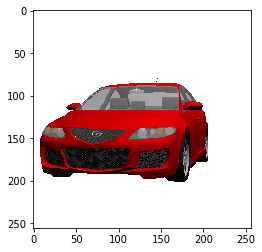

In [4]:
#this part is to visulize image
tmp = imageset[359]
print tmp.shape
plt.imshow(tmp/255)
plt.show()


In [5]:
#First 170 folders. 170*36 = 6120 images would be used for training
# rest 44 folders would be used for testing



data_ = np.zeros(imageset.shape)
labels_ = np.zeros(imageset.shape)
pose = np.zeros((5400,8,8,36))



for cnt in range(150):
    for itr in range(36):
        data_[(cnt*36) + itr] = imageset[cnt*36]
        pose_tmp = np.zeros(36)
        pose_tmp[itr] = 1
        pose[(cnt*36) + itr] = np.broadcast_to(pose_tmp,(8,8,36))
        labels_[(cnt*36) + itr] =  imageset[(cnt*36) + itr]
        print( (cnt*36) + itr)

data_, labels_, pose = shuffle(data_, labels_, pose, random_state=0)
#This code will generate labels for the dataset
#perm = np.random.permutation(data_.shape[0])

# data_ = data_[perm]
# labels_ = labels_[perm]
# pose = pose[perm]

# For current image label is the next image (image with 10 degree rotation)
# For last image in the set (36th image) label would be first image
data_train = np.array(data_[:4320])
data_test = np.array(data_[4320:])

train_labels = np.array(labels_[:4320])
test_labels = np.array(labels_[4320:])


# #Comment here for autoencoder
# for cnt in range(170):
#     train_labels[cnt*36:(cnt+1)*36] = np.roll(data_train[cnt*36:(cnt+1)*36], 1, axis=0)

# for cnt in range(46):
#     test_labels[cnt*36:(cnt+1)*36] = np.roll(data_test[cnt*36:(cnt+1)*36], 1, axis=0)
# # comment ends for same image autoencoder

#tmp = data_test[600]

#Hidden viewpoint block is generated here.
# For now it is same for all images. 10 degree angle change
# it will change afterwards

# view_1d = np.zeros(36)
# view_1d[1] = 1
# view = np.broadcast_to(view_1d,(7776,8,8,36))
# view_train = view[:6120]
# view_test = view[6120:]



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

MemoryError: 

In [ ]:

tmp = train_labels[10][...,::-1]
tmp1 = data_train[10][...,::-1]

print(pose[10][0][0])
plt.imshow(tmp1/255)
plt.show()
plt.imshow(tmp/255)
plt.show()


In [ ]:
#normalize data


data_train *= 2
data_train /= 255
data_train -= 1

data_test *= 2
data_test /= 255
data_test -= 1


train_labels *= 2
train_labels /= 255
train_labels -= 1

test_labels *= 2
test_labels /= 255
test_labels -= 1



In [ ]:
tf.reset_default_graph()
#to Reset Tensor Flow Graph

In [ ]:
#defination of my layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

def deconv2d(input, kernel_size, stride, num_filter):
    filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
    # tf.constant([input.get_shape()[0], input.get_shape()[1]*2, input.get_shape()[1]*2, num_filter], tf.int32)
    input_dim = input.get_shape().as_list()
    batch_size = input_dim[0]
    w = input_dim[1]
    out_shape = tf.stack([batch_size, w*2, w*2, num_filter])    

    stride_shape = [1, stride, stride, 1]
    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    
    return tf.nn.conv2d_transpose(input, W, out_shape, stride_shape)

In [ ]:

# Network Parameters

#Encoder
# input is 64 * 64 * 3 
# batch_size is 72


# tf Graph input (only pictures)

inputs_ = tf.placeholder(tf.float32, (36, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (36, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (36, 8, 8, 36), name="pose")

In [ ]:
# Building the encoder
#Layer Architecture
# Encoder will have Conv + relu + Max pool + Conv + relu  + Max pool + Conv + relu  + Max pool
# After 3 Convolution ,we will have a latent space

with tf.variable_scope('conv1'):
    conv1 = conv2d(inputs_, 3, 2, 16)
    tanh1 = tf.nn.relu(conv1)
    #pool1 = max_pool(tanh1, 3, 2)

# Size of pool1 would be 32*32*32

with tf.variable_scope('conv2'):
    conv2 = conv2d(tanh1, 3, 2, 32)
    tanh2 = tf.nn.relu(conv2)
    #pool2 = max_pool(tanh2, 3, 2)

# # Size of pool2 would be 16*16*16

with tf.variable_scope('conv3'):
    conv3 = conv2d(tanh2, 3, 2, 92)
    tanh3 = tf.nn.relu(conv3)
    #pool3 = max_pool(tanh3, 3, 2)

with tf.variable_scope('concat'):
    concat = tf.concat([tanh3, pose_], 3)
# # Latent space is 8*8*8
# print pool3.get_shape().as_list()
# #Building the decoder

with tf.variable_scope('deconv1'):
    deconv1 = deconv2d(concat, 3, 2, 32)
    tanh4 = tf.nn.relu(deconv1)

print tanh4.get_shape().as_list()
with tf.variable_scope('deconv2'):
    deconv2 = deconv2d(tanh4, 3, 2, 16)
    tanh5 = tf.nn.relu(deconv2)
print tanh5.get_shape().as_list()

with tf.variable_scope('deconv3'):
    deconv3 = deconv2d(tanh5, 3, 2, 3)
    tanh6 = tf.nn.tanh(deconv3)



In [ ]:

#calculate loss
loss_op = tf.reduce_mean(abs(tanh6 - targets_))

#Optimizer
global_step = tf.Variable(0,trainable=False)
lr = tf.train.exponential_decay(5e-4, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(lr)
train_op = optimizer.minimize(loss=loss_op)



In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training Parameters

epochs = 100
batch_size = 36
total_images = 6120

display_step = 1000
examples_to_show = 10


for e in range(epochs):
    for ii in range(total_images // batch_size):
        batch = data_train[ii*batch_size : (ii+1)*batch_size]
        batch_labels = train_labels[ii*batch_size : (ii+1)*batch_size]
        pose_labels = pose[ii*batch_size : (ii+1)*batch_size]
        feed_dict = {inputs_: batch, targets_: batch_labels, pose_:pose_labels}

        fetches = [train_op, loss_op]
        _, loss = sess.run(fetches, feed_dict=feed_dict)
    print("Epoch: {}/{}...".format(e+1, epochs),
            "Training loss: {:.4f}".format(loss))


In [ ]:

#compare test image 

tmp = imageset[6120+4][...,::-1]
print tmp.shape
plt.imshow(tmp/255)
plt.show()


In [ ]:


feed_dict = {inputs_: data_test[100:136], targets_: test_labels[100:136], pose_:pose[6120+100:6120+136]}

fetches = [tanh6, loss_op]
out, loss = sess.run(fetches, feed_dict=feed_dict)
print loss

In [ ]:
other = np.array(test_labels)

print other.shape

In [ ]:
# test_labels_copy = test_labels[0:72]

# test_labels_copy *= max_labels
# test_labels_copy += mean_labels

# tmp = test_labels_copy[36]

# tmp = np.where(tmp>255,255,tmp)
# tmp = np.where(tmp<0,0,tmp)
# tmp = tmp
# plt.imshow(tmp)
# plt.show()

In [ ]:

out += 1
out *=  255
out /= 2

# print np.amax(out)
# print np.amin(out)
# out = np.where(out>255,255,out)
# out = np.where(out<0,0,out)



In [ ]:

tmp = out[35]
print tmp.shape
plt.imshow(tmp/255)
plt.show()

In [ ]:
other += 1
other *=  255
other /= 2

In [ ]:
tmp = other[135]
plt.imshow(tmp/255)
plt.show()